In [6]:
#!/usr/bin/env python

import numpy as np
import pyopencl as cl

a_np = np.random.rand(50000000).astype(np.float32)
b_np = np.random.rand(50000000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void sum(
    __global const float *a_g, __global const float *b_g, __global float *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

[0. 0. 0. ... 0. 0. 0.]
0.0


In [5]:
#!/usr/bin/env python

import numpy as np
import pyopencl as cl

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void sum(
    __global const float *a_g, __global const float *b_g, __global float *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

[0. 0. 0. ... 0. 0. 0.]
0.0


In [1]:

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

NameError: name 'np' is not defined

In [14]:
import numpy as np
from numba import roc

@roc.jit
def add(a, b, c):
    i = roc.get_global_id(0)
    c[i] = a[i] + b[i]

# Initialize input arrays
N = 10
a = np.arange(N)
b = np.arange(N)
c = np.zeros(N, dtype=np.int32)

# Launch kernel
threads_per_block = 256
blocks_per_grid = (N + threads_per_block - 1) // threads_per_block

add[blocks_per_grid, threads_per_block](a, b, c)

# Print result
print("Result:", c)


ImportError: cannot import name 'roc' from 'numba' (c:\Users\lucam\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\__init__.py)

In [44]:
M, K, N = 1000, 1000, 100
a = np.random.rand(M, K).astype(np.float32)
b = np.random.rand(K, N).astype(np.float32)


In [47]:
import pyopencl as cl
import numpy as np
import time

# Define the OpenCL kernel code for matrix multiplication
kernel_code = """
__kernel void matrix_multiply(__global const float *a, __global const float *b, __global float *result, const int M, const int N, const int K) {
    int i = get_global_id(0);
    int j = get_global_id(1);
    if (i < M && j < N) {
        float sum = 0;
        for (int k = 0; k < K; ++k) {
            sum += a[i * K + k] * b[k * N + j];
        }
        result[i * N + j] = sum;
    }
}
"""

def cpu_matrix_multiply(a, b):
    return np.dot(a, b)

def gpu_matrix_multiply(a, b):
    times = []
    for j in range(-15, 15):
        t0 = time.time()
        thistimes = []

        # Set up OpenCL context, queue, and program
        platform = cl.get_platforms()[0]
        device = platform.get_devices()[0]
        context = cl.Context([device])
        queue = cl.CommandQueue(context)
        program = cl.Program(context, kernel_code).build()

        M, K = a.shape
        _, N = b.shape

        # Create OpenCL memory buffers
        a_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=a)
        b_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=b)
        result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, np.dtype(np.float32).itemsize * M * N)


        for k in range(3):
            for i in range(abs(j)):

                # Execute the kernel
                program.matrix_multiply(queue, (M, N), None, a_buf, b_buf, result_buf, np.int32(M), np.int32(N), np.int32(K))
            thistimes.append(time.time() - t0)

        # Read the result from the buffer
        result = np.empty((M, N), dtype=np.float32)
        cl.enqueue_copy(queue, result, result_buf).wait()
        
        
        times.append(np.mean(thistimes))
    return result, times

# Define the size of the matrices

# Generate random matrices

# Measure CPU execution time
start_time_cpu = time.time()
result_cpu = cpu_matrix_multiply(a, b)
end_time_cpu = time.time()
cpu_execution_time = end_time_cpu - start_time_cpu

# # Measure GPU execution time
start_time_gpu = time.time()
result_gpu, times = gpu_matrix_multiply(a, b)
end_time_gpu = time.time()
gpu_execution_time = end_time_gpu - start_time_gpu

print("CPU Execution Time:", cpu_execution_time)
print("GPU Execution Time:", gpu_execution_time)
print("Speedup Factor (CPU / GPU):", cpu_execution_time / gpu_execution_time)


CPU Execution Time: 0.001997709274291992
GPU Execution Time: 65.6618230342865
Speedup Factor (CPU / GPU): 3.0424212761330925e-05


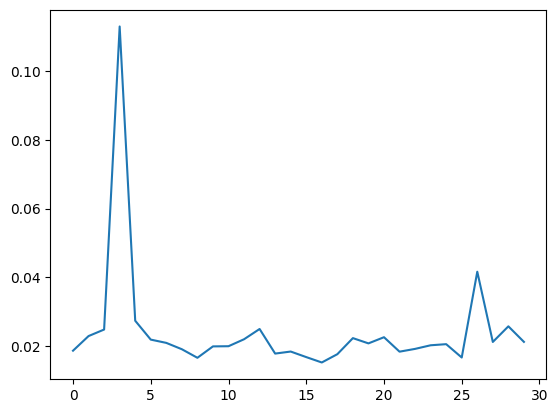

In [48]:
import matplotlib.pyplot as plt

plt.plot(times) # 3, 6

In [60]:
import pyopencl as cl
import numpy as np
import time

# Define the OpenCL kernel code for matrix multiplication
kernel_code = """
__kernel void matrix_multiply(__global const float *a, __global const float *b, __global float *result, const int M, const int N, const int K) {
    int i = get_global_id(0);
    int j = get_global_id(1);
    if (i < M && j < N) {
        float sum = 0;
        for (int k = 0; k < K; ++k) {
            sum += a[i * K + k] * b[k * N + j];
        }
        result[i * N + j] = sum;
    }
}
"""

def gpu_matrix_multiply(a, b):
    M, K = a.shape
    _, N = b.shape

    # Set up OpenCL context, queue, and program
    platform = cl.get_platforms()[0]
    device = platform.get_devices()[0]
    context = cl.Context([device])
    queue = cl.CommandQueue(context)
    program = cl.Program(context, kernel_code).build()

    # Create OpenCL memory buffers
    a_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=a)
    b_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=b)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, np.dtype(np.float32).itemsize * M * N)

    # Execute the kernel
    start_time = time.time()
    for i in range(10):
        program.matrix_multiply(queue, (M, N), None, a_buf, b_buf, result_buf, np.int32(M), np.int32(N), np.int32(K))
    queue.finish()
    end_time = time.time()

    # Read the result from the buffer
    result = np.empty((M, N), dtype=np.float32)
    cl.enqueue_copy(queue, result, result_buf).wait()

    return result, end_time - start_time

# Define the size of the matrices
M, K, N = 1000, 1000, 1000

# Generate random matrices
a = np.random.rand(M, K).astype(np.float32)
b = np.random.rand(K, N).astype(np.float32)

# Measure GPU execution time
result_gpu, gpu_execution_time = gpu_matrix_multiply(a, b)

print("GPU Execution Time:", gpu_execution_time)


GPU Execution Time: 28.34999132156372


In [61]:
%%time

c = np.dot(a, b)

CPU times: total: 891 ms
Wall time: 123 ms


In [15]:
import pyopencl as cl
import numpy as np
import time

# Define the OpenCL kernel code for batched matrix multiplication
kernel_code = """
__kernel void batched_matrix_multiply(__global const float *a, __global const float *b, __global float *result, const int num_batches, const int batch_size, const int M, const int N, const int K) {
    int batch_id = get_group_id(0);
    int i = get_global_id(1);
    int j = get_global_id(2);
    
    if (batch_id < num_batches && i < M && j < N) {
        float sum = 0;
        for (int k = 0; k < K; ++k) {
            sum += a[batch_id * M * K + i * K + k] * b[k * N + j];
        }
        result[batch_id * M * N + i * N + j] = sum;
    }
}
"""

def gpu_batched_matrix_multiply(a, b, num_batches):
    batch_size, M, K = a.shape
    _, N = b.shape

    # Set up OpenCL context, queue, and program
    platform = cl.get_platforms()[0]
    device = platform.get_devices()[0]
    context = cl.Context([device])
    queue = cl.CommandQueue(context)
    program = cl.Program(context, kernel_code).build()

    # Create OpenCL memory buffers
    a_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=a)
    b_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=b)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, np.dtype(np.float32).itemsize * num_batches * M * N)

    # Execute the kernel to perform batched matrix multiplication
    start_time = time.time()
    program.batched_matrix_multiply(queue, (num_batches, M, N), None, a_buf, b_buf, result_buf, np.int32(num_batches), np.int32(batch_size), np.int32(M), np.int32(N), np.int32(K))
    queue.finish()
    end_time = time.time()

    # Read the result from the buffer
    result = np.empty((num_batches, M, N), dtype=np.float32)
    cl.enqueue_copy(queue, result, result_buf).wait()

    return result, end_time - start_time

data = []

# Define the size of the matrices and batch size
batch_size, M, K, N = 512, 150, 150, 150

# Generate random matrices
a = np.random.rand(batch_size, M, K).astype(np.float32)
b = np.random.rand(K, N).astype(np.float32)

t0 = time.time()
# Measure GPU execution time
result_gpu, gpu_execution_time = gpu_batched_matrix_multiply(a, b, batch_size)

print("GPU Execution Time:", gpu_execution_time)


GPU Execution Time: 0.13497066497802734


In [16]:
(result_gpu - np.dot(a, b) < 0.0001).mean()

1.0

GPU Execution Time: 0.031269073486328125


In [132]:
timings = np.array(data)[:, 0]
batch = np.array(data)[:, 1]


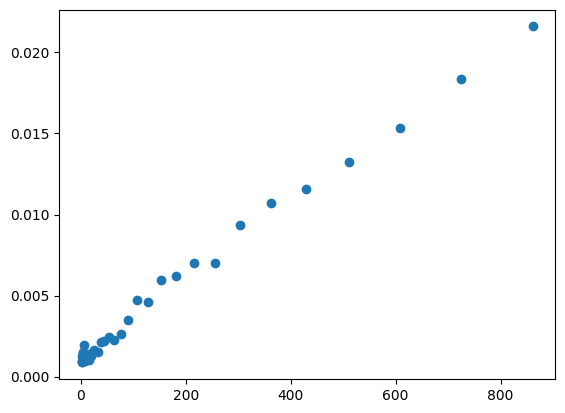

In [109]:
import matplotlib.pyplot as plt
plt.scatter(timings[:], batch[:])

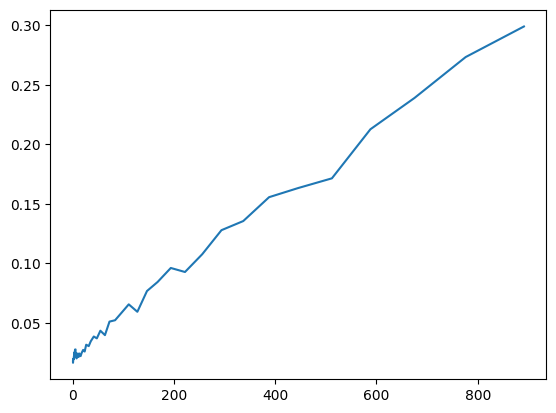

In [124]:
import matplotlib.pyplot as plt
plt.plot(timings, batch)

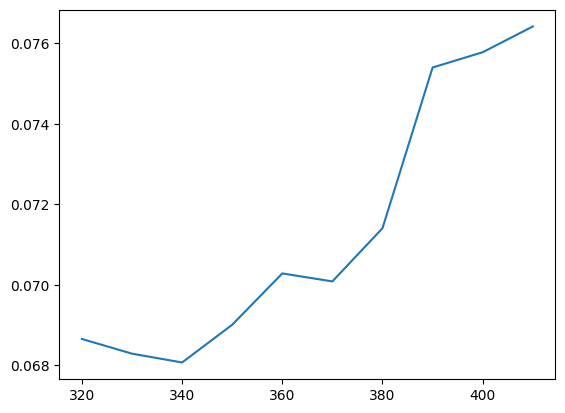

In [134]:
import matplotlib.pyplot as plt
plt.plot(timings, batch)

In [112]:
%%time
a = np.random.rand(batch_size, M, K).astype(np.float32)
b = np.random.rand(K, N).astype(np.float32)

c = np.dot(a, b)

CPU times: total: 422 ms
Wall time: 546 ms


In [20]:
import numpy as np
import pyopencl as cl
import time 

kernel_code = """
__kernel void batched_matrix_multiply(__global const float *a, __global const float *b, __global float *result, const int num_batches, const int batch_size, const int M) {
    int batch_id = get_group_id(0);
    int i = get_global_id(1);
    
    if (batch_id < num_batches && i < M) {
        result[batch_id * M + i] = a[batch_id * M + i] + b[batch_id * M + i];
    }
}
"""

type = np.float32

def gpu_batched_matrix_multiply(a, b, num_batches):
    batch_size, M = a.shape

    # Set up OpenCL context, queue, and program
    platform = cl.get_platforms()[0]
    device = platform.get_devices()[0]
    context = cl.Context([device])
    queue = cl.CommandQueue(context)
    program = cl.Program(context, kernel_code).build()

    start_time = time.time()
    # Create OpenCL memory buffers
    a_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=a)
    b_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=b)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, np.dtype(type).itemsize * num_batches * M)

    # Execute the kernel to perform batched matrix addition
    program.batched_matrix_multiply(queue, (num_batches, M), None, a_buf, b_buf, result_buf, np.int32(num_batches), np.int32(batch_size), np.int32(M))
    queue.finish()
    end_time = time.time()

    # Read the result from the buffer
    result = np.empty((num_batches, M), dtype=np.float16)
    cl.enqueue_copy(queue, result, result_buf).wait()

    return result, end_time - start_time

# Define the size of the matrices and batch size
batch_size, M = 2560, 1000

# Generate random matrices
a = np.random.rand(batch_size, M)
b = np.random.rand(batch_size, M)

# Measure GPU execution time
result_gpu, gpu_execution_time = gpu_batched_matrix_multiply(a.astype(type), b.astype(type), batch_size)
print("GPU Execution Time:", gpu_execution_time)


GPU Execution Time: 0.03999447822570801


# Most of the time is taken by Buffer creation
# lazy iterations should be really fast

In [ ]:
%%time

print(a.shape, b.shape)
for i in range(1): c = a+b

(25600, 10000) (25600, 10000)
CPU times: total: 500 ms
Wall time: 562 ms


In [273]:
(result_gpu == a + b).all()

True

In [8]:
import pyopencl as cl
import numpy as np
import time

# Define the OpenCL kernel code for batched matrix multiplication
kernel_code = """
__kernel void batched_matrix_multiply(__global const float *a, __global const float *b, __global float *result, const int num_batches, const int batch_size, const int M, const int N, const int K) {
    int batch_id = get_global_id(0);
    int i = get_global_id(1);
    int j = get_global_id(2);
    
    if (batch_id < num_batches && i < M && j < N) {
        float sum = 0;
        for (int k = 0; k < K; ++k) {
            sum += a[batch_id * M * K + i * K + k] * b[k * N + j];
        }
        result[batch_id * M * N + i * N + j] = sum;
    }
}
"""


class BatchedMatrixMultiplier:
    def __init__(self, a, b):
        # Set up OpenCL context, queue, and program
        platform = cl.get_platforms()[0]
        device = platform.get_devices()[0]
        self.context = cl.Context([device])
        self.queue = cl.CommandQueue(self.context)
        self.program = cl.Program(self.context, kernel_code).build()

        # Initialize OpenCL memory buffers
        self.a_buf = cl.Buffer(self.context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=a)
        self.b_buf = cl.Buffer(self.context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=b)
        self.num_batches, self.M, self.K = a.shape
        _, self.N = b.shape
        self.result_buf = cl.Buffer(self.context, cl.mem_flags.WRITE_ONLY, np.dtype(np.float32).itemsize * self.num_batches * self.M * self.N)

    def batched_matrix_multiply(self, a, b):
        # Update OpenCL memory buffers with new data
        cl.enqueue_copy(self.queue, self.a_buf, a).wait()
        cl.enqueue_copy(self.queue, self.b_buf, b).wait()

        # Execute the kernel to perform batched matrix multiplication
        start_time = time.time()
        self.program.batched_matrix_multiply(self.queue, (self.num_batches, self.M, self.N), None, self.a_buf, self.b_buf, self.result_buf, np.int32(self.num_batches), np.int32(self.num_batches), np.int32(self.M), np.int32(self.N), np.int32(self.K))
        self.queue.finish()
        end_time = time.time()

        # Read the result from the buffer
        result = np.empty((self.num_batches, self.M, self.N), dtype=np.float32)
        cl.enqueue_copy(self.queue, result, self.result_buf).wait()

        return result, end_time - start_time

# Define the size of the matrices and batch size
batch_size, M, K, N = 8, 256, 256, 256

# Generate random matrices
a = np.random.rand(batch_size, M, K).astype(np.float32)
b = np.random.rand(K, N).astype(np.float32)

# Create BatchedMatrixMultiplier instance
multiplier = BatchedMatrixMultiplier(a, b)

# Measure GPU execution time
result_gpu, gpu_execution_time = multiplier.batched_matrix_multiply(a, b)

print("GPU Execution Time:", gpu_execution_time)


GPU Execution Time: 0.1238412857055664


In [11]:
(result_gpu - np.dot(a, b) < 0.0001).all()

True

In [12]:
%%time
a@b

CPU times: total: 0 ns
Wall time: 10 ms


array([[[64.48555 , 66.61109 , 71.8162  , ..., 66.37271 , 66.85239 ,
         66.5025  ],
        [62.051796, 63.337677, 68.510025, ..., 61.41051 , 59.8599  ,
         63.11222 ],
        [59.683723, 60.519554, 65.12445 , ..., 61.96913 , 61.934944,
         62.189133],
        ...,
        [61.71576 , 64.26009 , 69.51359 , ..., 63.46204 , 66.435616,
         66.06518 ],
        [63.44071 , 62.529793, 69.50688 , ..., 64.02523 , 64.20534 ,
         66.455765],
        [58.99486 , 62.682953, 64.876114, ..., 62.176422, 60.608368,
         60.754993]],

       [[64.82254 , 66.09009 , 71.33217 , ..., 64.80196 , 67.410286,
         67.354904],
        [61.48259 , 61.028687, 69.508514, ..., 63.99273 , 61.7332  ,
         62.538467],
        [62.935543, 61.120125, 67.49665 , ..., 61.785385, 62.923046,
         63.105286],
        ...,
        [61.466827, 62.68963 , 66.1929  , ..., 64.34442 , 62.158676,
         61.298588],
        [62.099667, 62.965977, 68.29418 , ..., 61.826195, 62.027092,
   

In [2]:
2048*256**3

34359738368

In [3]:
4096**3

68719476736

In [ ]:
result_gpu, gpu_execution_time = multiplier.batched_matrix_multiply(a, b)
gpu_execution_time

1.7778708934783936

In [ ]:
%%time
c = np.dot(a[:], b)

CPU times: total: 27.8 s
Wall time: 39.1 s


In [81]:
import torch

In [82]:
a = torch.randn(512*4, 256, 256)
b = torch.randn(256, 256)


In [83]:
%%time
(a@b).shape


CPU times: total: 3.03 s
Wall time: 664 ms


torch.Size([2048, 256, 256])

In [76]:
256**4 * 4 / 1024**3


16.0

In [88]:
((result_gpu - (a @ b)) < 0.000000000001).mean()

0.9993178173899651

In [42]:
result_gpu[0], (a @ b)[0]

(array([[61.820065, 61.55171 , 65.66953 , ..., 64.86854 , 66.393616,
         62.9726  ],
        [59.756557, 61.9862  , 66.99809 , ..., 64.49959 , 66.781845,
         64.666756],
        [57.12191 , 59.704445, 61.76657 , ..., 60.52001 , 63.222786,
         60.647137],
        ...,
        [57.793705, 63.585346, 63.312244, ..., 66.19197 , 64.53937 ,
         63.53017 ],
        [61.118217, 65.39645 , 65.559044, ..., 65.36308 , 65.02639 ,
         63.323223],
        [60.3912  , 62.915504, 65.13879 , ..., 65.56246 , 65.285835,
         65.952866]], dtype=float32),
 array([[61.82005 , 61.55169 , 65.66954 , ..., 64.86854 , 66.393616,
         62.9726  ],
        [59.75656 , 61.9862  , 66.99811 , ..., 64.49959 , 66.781845,
         64.66677 ],
        [57.121906, 59.704453, 61.76656 , ..., 60.52001 , 63.22279 ,
         60.647133],
        ...,
        [57.793705, 63.585342, 63.312244, ..., 66.19197 , 64.53937 ,
         63.53017 ],
        [61.118217, 65.39645 , 65.559044, ..., 65.36309 ,